In [1]:
import time
import queue
import pandas as pd
import threading
from typing import Union, List
from tqdm import tqdm
from pathlib import Path
import numpy as np
from datasets import Dataset
from transformers import PreTrainedTokenizerFast
from tokenizers.processors import TemplateProcessing
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
from Bio.Seq import translate

PathLike = Union[str, Path]
import re
import os

# from genslm.utils import read_fasta_only_seq, read_fasta, Sequence

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
}


def group_and_contextualize_cpe(seq: str, k: int = 3):
    return " ".join(CODON_CHAR.get(seq[i : i + k], "") for i in range(0, len(seq), k))


class SequenceReader:
    def __init__(self, fasta_file: Path) -> None:
        self.finished = False
        self.queue = queue.Queue()
        self.thread = threading.Thread(
            target=self.read_fasta, args=(fasta_file,), daemon=True
        )
        self.thread.start()

    def read_fasta(self, fasta_file: Path):
        """Reads sequences one by one from a fasta file and yields the result"""
        current_sequence = []
        with open(fasta_file, "r") as file:
            for line in file:
                line = line.strip()
                if line.startswith(">"):
                    # Edge case at the start of the file
                    if current_sequence:
                        sequence = group_and_contextualize(
                            "".join(current_sequence).upper()
                        )
                        self.queue.put(sequence)
                        current_sequence = []
                else:
                    current_sequence.append(line)

            # Edge case for the final sequence
            if current_sequence:
                sequence = group_and_contextualize("".join(current_sequence).upper())
                self.queue.put(sequence)

        self.finished = True

    def __iter__(self):
        i = 0
        while not (self.finished and self.queue.empty()):
            try:
                yield self.queue.get_nowait()
            except queue.Empty:
                time.sleep(1)  # Wait a second for the queue to fill
                continue

            i += 1
            if i % 50000 == 0:
                print(f"Qsize: {self.queue.qsize()}")


def fasta_corpus_iterator(fasta_file: Union[Path, List[Path]]):
    """Iterates over a set of fasta files one sequence at a time.

    Note: Does not skip any sequences, if a sequence length is not
    divisible by 3, it is truncated.
    """
    fasta_file = [fasta_file] if isinstance(fasta_file, Path) else fasta_file
    print("Reading sequences")
    for file in fasta_file:
        for sequence in tqdm(SequenceReader(file)):
            yield sequence


def build_tokenizer(corpus_iterator, vocab_size=50_257, add_bos_eos: bool = True):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }
    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(models.BPE())

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size, special_tokens=list(special_tokens.values())
    )

    print("Training tokenizer")
    tokenizer.train_from_iterator(corpus_iterator, trainer=trainer)

    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, **special_tokens
    )

    return wrapped_tokenizer

/home/couchbucks/Documents/saketh/cpe/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def group_and_contextualize_split_every_n(seq: str, n):
    seq.replace(" ", "")
    remainder = len(seq) % n
    if remainder != 0:
        seq = seq[:-remainder]  # Remove the last remainder characters
    substrings = [seq[i : i + n] for i in range(0, len(seq), n)]
    return " ".join(substrings)

In [3]:
def make_str_div(seq, n):
    remainder = len(seq) % n
    # print(remainder)
    if remainder != 0:
        seq = seq[:-remainder]

    return seq

Order of tokenizers: json files -> saved_tokenizers
1. codon_wordlevel
2. dna_wordlevel
3. protein_alphabet_wordlevel
4. ape_tokenizer
5. cpe_tokenizer
6. npe_tokenizer

In [4]:
current_tokenizer_name = "cpe_tokenizer with mdh seqs"

In [30]:
# sequence_file = Path("/home/couchbucks/Downloads/all_fasta_files/dna_classification_sequences.fasta")
# start = time.time()
# reader = SequenceReader(sequence_file)
# seqeunces = fasta_corpus_iterator(sequence_file)
tokenizer_path = "tokenizers/saved_tokenizers/cpe_tokenizer"
if os.path.isfile(tokenizer_path):
    # tokenizer = PreTrainedTokenizerFast(
    #     tokenizer_object=Tokenizer.from_file(config.tokenizer_path),
    # )
    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
    print("inside")
else:
    tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
# print("Tokenizer time:", time.time() - start)

In [6]:
def read_fasta_only_seq(fasta_file: PathLike) -> List[str]:
    """Reads fasta file sequences without description tag."""
    text = Path(fasta_file).read_text()
    pattern = re.compile("^>", re.MULTILINE)
    non_parsed_seqs = re.split(pattern, text)[1:]
    lines = [
        line.replace("\n", "") for seq in non_parsed_seqs for line in seq.split("\n", 1)
    ]

    return lines[1::2]

# HuggingFace Codon-Pair-Ecoding Tokenizer

In [29]:
sequence_file = Path(
    "/home/couchbucks/Downloads/all_fasta_files/mdh_natural_sequences.ffn"
)
sequences = read_fasta_only_seq(sequence_file)
sequences = [make_str_div(seq.upper(), 3) for seq in sequences if len(seq) > 3]

# sequences = np.array([group_and_contextualize(seq.upper()) for seq in sequences if len(seq) % 3 == 0])

In [8]:
sequences = [group_and_contextualize_cpe(seq) for seq in sequences]

In [12]:
seq = sequences[589]

In [31]:
vocab = tokenizer.vocab
keys_0_to_10 = [key for key, value in vocab.items() if 0 <= value <= 10]
print(keys_0_to_10)

['0', '[MASK]', '!', '[BOS]', '[PAD]', '[EOS]', '1', '[SEP]', '[CLS]', '[UNK]', '2']


In [32]:
"""
"zz": 71,
      "ww": 72,
      "qq": 73,
      "IE": 74,
      "Iz": 75,
      "wz": 76,
      "zq": 77,
      "Iq": 78,
      "wE": 79,
      "wq": 80,
      "Dq": 81,
      "II": 82,
"""

'\n"zz": 71,\n      "ww": 72,\n      "qq": 73,\n      "IE": 74,\n      "Iz": 75,\n      "wz": 76,\n      "zq": 77,\n      "Iq": 78,\n      "wE": 79,\n      "wq": 80,\n      "Dq": 81,\n      "II": 82,\n'

In [39]:
seq = "z z w w q q I E q q I z"

# It should tokenize: 71, 72, 73, 74, 73, 75

In [57]:
import torch

print(seq)
len(
    torch.flatten(
        tokenizer(
            seq,
            max_length=1024,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"]
    )
)

z z w w q q I E q q I z


1024

In [49]:
tokenizer.tokenize(seq)

['zzww', 'qqIE', 'qq', 'Iz']

In [47]:
print(
    "One line Code Key value: ", list(vocab.keys())[list(vocab.values()).index(15420)]
)

One line Code Key value:  qqIE


In [100]:
special_tokens = {
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "pad_token": "[PAD]",
    "mask_token": "[MASK]",
    "bos_token": "[BOS]",
    "eos_token": "[EOS]",
}

# print(tokenizer)
# special_token_list = [special_tokens.get(key) for key in special_tokens.keys()]
tokenizer.add_special_tokens(special_tokens)

0

In [101]:
def seq_to_codon_list(seq: str) -> List[str]:
    """split the sequence string into strings of len 3"""
    return [seq[i : i + 3] for i in range(0, len(seq), 3)]

In [ ]:
vocab = tokenizer.vocab
print(vocab)
print(i for i in vocab if vocab[i] == 3)

In [105]:
tokenized_seqs = tokenizer(
    sequences[0],
    max_length=1024,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)

In [113]:
import torch

In [125]:
print(len(torch.unique(tokenized_seqs["input_ids"])))

148


In [126]:
unique_lens = []

for seq in sequences:
    tokenized_seqs = tokenizer(
        seq, max_length=1024, padding="max_length", truncation=True, return_tensors="pt"
    )
    unique_lens.append(len(torch.unique(tokenized_seqs["input_ids"])))

print(len(unique_lens))
print(sum(unique_lens))

print(sum(unique_lens) / len(unique_lens))

36631
5385652
147.02443285741586


In [129]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

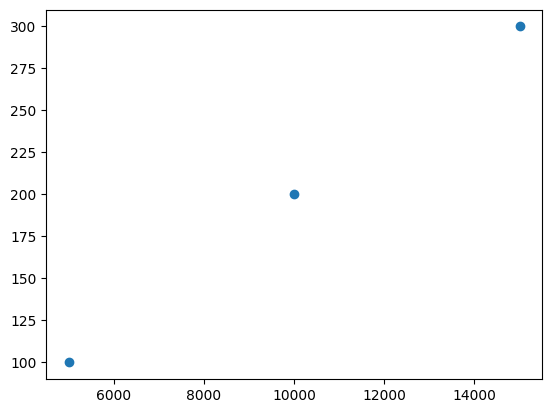

In [131]:
unique_lens_dict = {5000: 100, 10000: 200, 15000: 300}

plt.scatter(unique_lens_dict.keys(), unique_lens_dict.values())
plt.show

In [208]:
# dataset_seqs = [group_and_contextualize(seq.upper()) for seq in sequences]

unique_lens = []

for seq in sequences:
    tokenized_seqs = tokenizer(
        seq, max_length=1024, padding="max_length", truncation=True, return_tensors="pt"
    )
    unique_lens.append(len(torch.unique(tokenized_seqs["input_ids"])))


data = {
    "input_ids": tokenized_seqs.input_ids.tolist(),
    "attention_mask": tokenized_seqs.attention_mask.tolist(),
}

dataset = Dataset.from_dict(data)
print(dataset)

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 30000
})


In [209]:
# See average length
tokenized_lens = [sum(elem["attention_mask"]) for elem in dataset]
pd.DataFrame(tokenized_lens).describe()

,0
count,30000.000000
mean,172.300433
std,14.504463
min,128.000000
25%,161.000000
50%,175.000000
75%,183.000000
max,212.000000


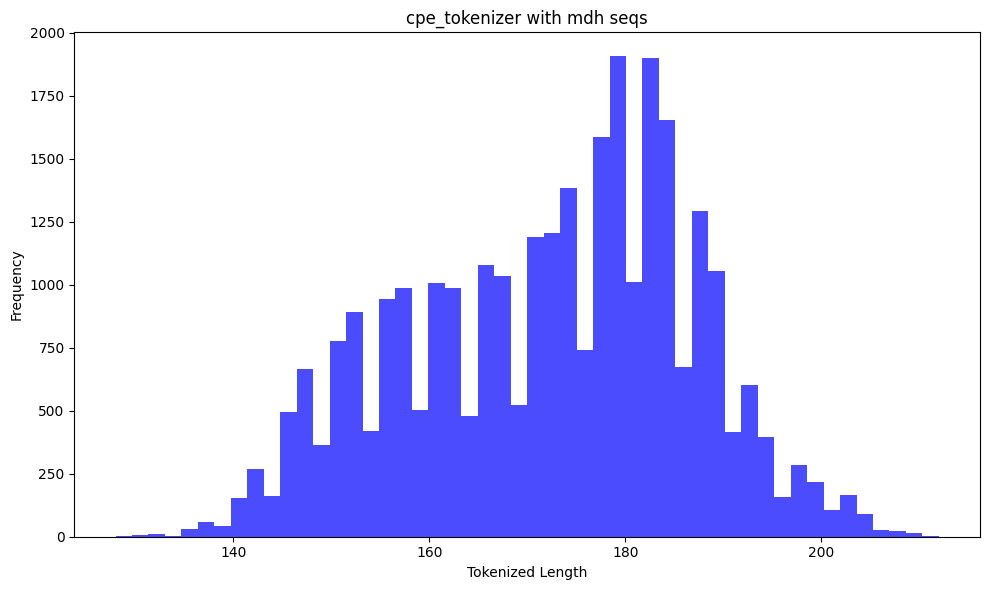

In [210]:
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.hist(tokenized_lens, bins=50, color="blue", alpha=0.7)

# Setting title and labels
plt.title(current_tokenizer_name)
plt.xlabel("Tokenized Length")
plt.ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

                  0
count  50257.000000
mean       4.032254
std        1.957558
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max       44.000000


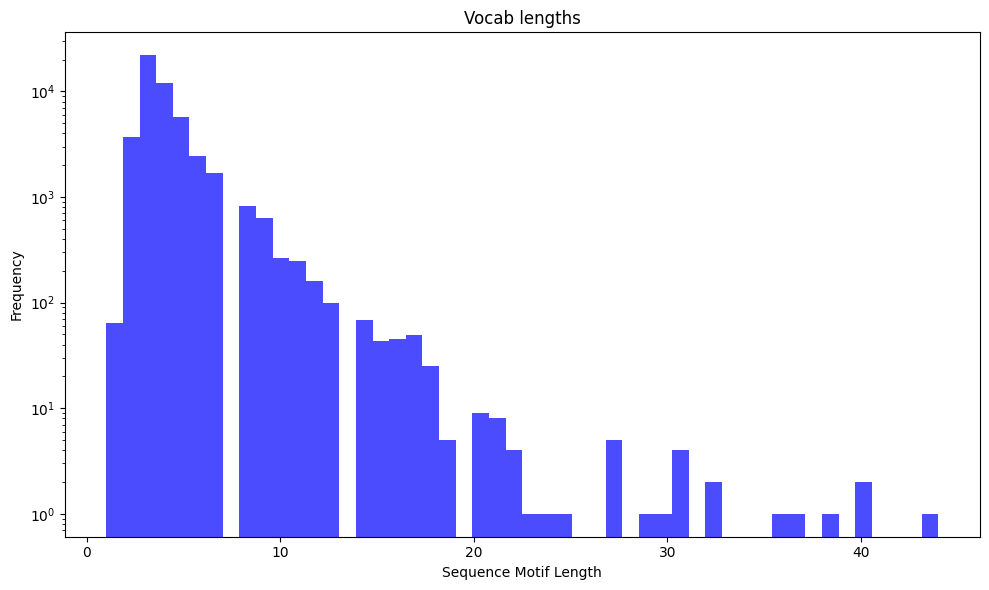

In [10]:
# plot of vocab sequence lengths
vocab_lens = [len(elem) for elem in tokenizer.get_vocab().keys()]

import pandas as pd

df = pd.DataFrame(vocab_lens)
print(df.describe())

# Set up the figure and axes
plt.figure(figsize=(10, 6))

# Plotting the histogram
plt.hist(vocab_lens, bins=50, color="blue", alpha=0.7)
plt.yscale("log")

# Setting title and labels
plt.title("Vocab lengths")
plt.xlabel("Sequence Motif Length")
plt.ylabel("Frequency")

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
sequence_file = Path(
    "/lambda_stor/homes/khippe/genslm_foundation/genome_data/curriculum_datasets/homology-90-50/codon_homology/pgfam_30k_all.ffn"
)
sequences = read_fasta_only_seq(sequence_file)
sequences = np.array(
    [
        group_and_contextualize(seq.upper())
        for seq in tqdm(sequences)
        if len(seq) % 3 == 0
    ]
)

  9%|████████████▍                                                                                                                                   | 9628131/110953201 [11:29<1:45:16, 16040.33it/s]

In [2]:
# define a BPE training iterator

sequence_file = Path(
    "/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn"
)
sequences = read_fasta(sequence_file)


def get_mdh_raw_sequences():
    for sequence in sequences:
        yield sequence.sequence.upper()

In [7]:
# Define cBPE training iterator

# Sequence pre-processing helpers
# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
}


def group_and_contextualize(seq: str, k: int = 3):
    grouped_codons = " ".join(seq[i : i + k] for i in range(0, len(seq), k)).upper()
    # Removes all modulo 3 chars
    return "".join(CODON_CHAR.get(codon, "") for codon in grouped_codons.split())


def decode_grouped_context(seq: str, sep: str = " "):
    return sep.join(CHAR_CODON[elem] for elem in seq)


def group_by_kmer(seq: str, kmer: int) -> str:
    return " ".join(seq[i : i + kmer] for i in range(0, len(seq), kmer)).upper()


sequence_file = Path(
    "/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn"
)
sequences = read_fasta(sequence_file)

# Define iterator
grouped_sequences = []  # Group by 3-mer (codon)
skipped = 0
for seq in sequences:
    if len(seq.sequence) % 3 != 0:
        skipped += 1
        continue
    grouped_sequences.append(group_by_kmer(seq.sequence, 3))

codon_pairs = [
    "".join(CODON_CHAR[codon] for codon in seq.split()) for seq in grouped_sequences
]  # Convert codons to unique chars
print(f"Skipped {skipped} sequences for non-translatable length")


def get_mdh_codon_tokens():
    for seq in codon_pairs:
        yield seq

Skipped 7 sequences for non-translatable length


In [12]:
def build_tokenizer(corpus_function, vocab_size=50_257, add_bos_eos: bool = True):
    special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }
    bos_index = 5
    eos_index = 6

    # Define tokenizer
    tokenizer = Tokenizer(models.BPE())

    trainer = trainers.BpeTrainer(
        vocab_size=vocab_size, special_tokens=list(special_tokens.values())
    )

    print("Training tokenizer")
    tokenizer.train_from_iterator(corpus_function(), trainer=trainer)

    # Add post-processor
    # trim_offsets=True will ignore spaces, false will leave them in
    tokenizer.post_processor = processors.ByteLevel(trim_offsets=False)
    if add_bos_eos:
        tokenizer.post_processor = TemplateProcessing(
            single="[BOS] $A [EOS]",
            special_tokens=[("[BOS]", bos_index), ("[EOS]", eos_index)],
        )

    # Add a decoder
    tokenizer.decoder = decoders.ByteLevel()

    # save the tokenizer
    wrapped_tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer, *special_tokens
    )

    return wrapped_tokenizer

In [ ]:
bpe_output_path = Path("mdh-bpe")
if not bpe_output_path.exists():
    mdh_bpe = build_tokenizer(
        get_mdh_raw_sequences, vocab_size=50_257, add_bos_eos=True
    )
    mdh_bpe.save_pretrained(bpe_output_path)
else:
    print(f"Loading from {bpe_output_path}")
    mdh_bpe = PreTrainedTokenizerFast.from_pretrained(bpe_output_path)

In [13]:
codon_bpe_output_path = Path("mdh-codon-bpe")

if not codon_bpe_output_path.exists():
    start = time.time()
    mdh_codon_bpe = build_tokenizer(
        get_mdh_codon_tokens, vocab_size=50_257, add_bos_eos=True
    )
    print("Tokenizer time:", time.time() - start)
    mdh_codon_bpe.save_pretrained(codon_bpe_output_path)
else:
    print(f"Loading from {codon_bpe_output_path}")
    mdh_codon_bpe = PreTrainedTokenizerFast.from_pretrained(codon_bpe_output_path)

Training tokenizer



Tokenizer time: 37.2101776599884


# Vocab Size Experiments


In [6]:
# 30k
cBPE_30k_output_path = Path("mdh-codon-bpe-vs30000")
vocab_size = 30_000
cBPE_30k = build_tokenizer(
    get_mdh_codon_tokens, vocab_size=vocab_size, add_bos_eos=True
)
cBPE_30k.save_pretrained(cBPE_30k_output_path)

Training tokenizer





('mdh-codon-bpe-vs30000/tokenizer_config.json',
 'mdh-codon-bpe-vs30000/special_tokens_map.json',
 'mdh-codon-bpe-vs30000/tokenizer.json')

In [7]:
# 20k
cBPE_20k_output_path = Path("mdh-codon-bpe-vs20000")
vocab_size = 20_000
cBPE_30k = build_tokenizer(
    get_mdh_codon_tokens, vocab_size=vocab_size, add_bos_eos=True
)
cBPE_30k.save_pretrained(cBPE_20k_output_path)

Training tokenizer





('mdh-codon-bpe-vs20000/tokenizer_config.json',
 'mdh-codon-bpe-vs20000/special_tokens_map.json',
 'mdh-codon-bpe-vs20000/tokenizer.json')

In [8]:
# 10k
cBPE_10k_output_path = Path("mdh-codon-bpe-vs10000")
vocab_size = 10_000
cBPE_30k = build_tokenizer(
    get_mdh_codon_tokens, vocab_size=vocab_size, add_bos_eos=True
)
cBPE_30k.save_pretrained(cBPE_10k_output_path)

Training tokenizer





('mdh-codon-bpe-vs10000/tokenizer_config.json',
 'mdh-codon-bpe-vs10000/special_tokens_map.json',
 'mdh-codon-bpe-vs10000/tokenizer.json')

# Full Patric BPE tokenizer

In [ ]:
from tqdm import tqdm

patric_sequence_file = Path(
    "/lambda_stor/homes/khippe/genslm_foundation/genome_data/curriculum_datasets/homology-90-50/codon_homology/pgfam_30k_all.ffn"
)
patric_sequences = read_fasta(patric_sequence_file)
print(f"Read {len(patric_sequences)} sequences")

# Define iterator
patric_codon_pairs = [group_and_contextualize(seq.sequence) for seq in patric_sequences]
del patric_sequences  # free memory


def get_patric_codon_tokens():
    for seq in patric_codon_pairs:
        yield seq

In [ ]:
vocab_size = 50257
patric_cBPE_50k_output_path = Path("patric-codon-bpe-vs50257")
patric_cBPE_50k = build_tokenizer(
    get_patric_codon_tokens, vocab_size=vocab_size, add_bos_eos=True
)
patric_cBPE_50k.save_pretrained(patric_cBPE_50k_output_path)

# Modelling

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from pathlib import Path

import accelerate
import datasets
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
from transformers import PreTrainedTokenizerFast
from transformers import BertConfig, BertForMaskedLM


from genslm.utils import read_fasta, Sequence

In [ ]:
# Setup Tokenizer
special_tokens = {
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "pad_token": "[PAD]",
    "mask_token": "[MASK]",
    "bos_token": "[BOS]",
    "eos_token": "[EOS]",
}

tokenizer = PreTrainedTokenizerFast.from_pretrained("mdh-codon-bpe")
tokenizer.add_special_tokens(special_tokens)
None

In [ ]:
# Sequence pre-processing helpers

CODON_MAP = {
    "TCG": 0,
    "GCA": 1,
    "CTT": 2,
    "ATT": 3,
    "TTA": 4,
    "GGG": 5,
    "CGT": 6,
    "TAA": 7,
    "AAA": 8,
    "CTC": 9,
    "AGT": 10,
    "CCA": 11,
    "TGT": 12,
    "GCC": 13,
    "GTT": 14,
    "ATA": 15,
    "TAC": 16,
    "TTT": 17,
    "TGC": 18,
    "CAC": 19,
    "ACG": 20,
    "CCC": 21,
    "ATC": 22,
    "CAT": 23,
    "AGA": 24,
    "GAG": 25,
    "GTG": 26,
    "GGT": 27,
    "GCT": 28,
    "TTC": 29,
    "AAC": 30,
    "TAT": 31,
    "GTA": 32,
    "CCG": 33,
    "ACA": 34,
    "CGA": 35,
    "TAG": 36,
    "CTG": 37,
    "GGA": 38,
    "ATG": 39,
    "TCT": 40,
    "CGG": 41,
    "GAT": 42,
    "ACC": 43,
    "GAC": 44,
    "GTC": 45,
    "TGG": 46,
    "CCT": 47,
    "GAA": 48,
    "TCA": 49,
    "CAA": 50,
    "AAT": 51,
    "ACT": 52,
    "GCG": 53,
    "GGC": 54,
    "CTA": 55,
    "AAG": 56,
    "AGG": 57,
    "CAG": 58,
    "AGC": 59,
    "CGC": 60,
    "TTG": 61,
    "TCC": 62,
    "TGA": 63,
}

# Assign a unique character to each codon so that we can use it as an
# input token to a BPE tokenizer. This implements a codon-pair encoding.
CODON_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
}


def group_and_contextualize(seq: str, k: int = 3):
    grouped_codons = " ".join(seq[i : i + k] for i in range(0, len(seq), k)).upper()
    # Removes all modulo 3 chars
    return "".join(CODON_CHAR.get(codon, "") for codon in grouped_codons.split())

In [ ]:
# Dataset
sequence_file = Path(
    "/lambda_stor/homes/khippe/genslm_foundation/genome_data/mdh_sc23/fasta/mdh_natural_sequences.ffn"
)
sequences = read_fasta(sequence_file)


dataset_seqs = [group_and_contextualize(seq.sequence) for seq in sequences]
tokenized_seqs = tokenizer(
    dataset_seqs,
    max_length=1024,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)


data = {
    "input_ids": tokenized_seqs.input_ids.tolist(),
    "attention_mask": tokenized_seqs.attention_mask.tolist(),
}

dataset = Dataset.from_dict(data)
dataset = dataset.train_test_split(test_size=0.05)
print(dataset)

In [ ]:
# Modelling

# 124,690,513 params
config = BertConfig(
    hidden_size=512,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=2048,
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    max_position_embeddings=1024,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = BertForMaskedLM(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"BERT size: {model_size/1000**2:.1f}M parameters")

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True)

In [ ]:
# Trainer

args = TrainingArguments(
    output_dir="mdh-cBPE-BERT-50m",
    per_device_train_batch_size=28,
    per_device_eval_batch_size=28,
    evaluation_strategy="steps",
    eval_steps=50,
    logging_steps=25,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=500,
    fp16=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

In [ ]:
trainer.train()

In [ ]:
# Modelling

# 124,690,513 params
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    pad_token_id=tokenizer.pad_token_id,
    max_position_embeddings=1024,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = BertForMaskedLM(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"BERT size: {model_size/1000**2:.1f}M parameters")

data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True)

# Trainer

args = TrainingArguments(
    output_dir="mdh-cBPE-BERT-125m",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=50,
    logging_steps=25,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=500,
    fp16=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)
trainer.train()